In [ ]:
import numpy as np
import torch
import torch.nn as nn


from core.operations import FFTConvolver


np.random.seed(42)
torch.manual_seed(42)

# test parameters
B = 2        
C_in = 3     
H = 32       
W = 32       
C_out = 4    
KH = 7       
KW = 7       
stride = 2   
padding = 1  

# Generate random input and kernels
input_np = np.random.randn(B, C_in, H, W)
kernels_np = np.random.randn(C_out, C_in, KH, KW)

# Compute output using FFTConvolver
convolver = FFTConvolver()
output_fft = convolver.convolve(input_np, kernels_np, stride=stride, padding=padding)

# Compute output using PyTorch
input_torch = torch.tensor(input_np, dtype=torch.float64)
kernels_torch = torch.tensor(kernels_np, dtype=torch.float64)
conv = nn.Conv2d(C_in, C_out, kernel_size=KH, stride=stride, padding=padding, bias=False, dtype=torch.float64)
conv.weight.data = kernels_torch
with torch.no_grad():
    output_torch = conv(input_torch).numpy()

# Verify shapes
print("FFTConvolver output shape:", output_fft.shape)
print("PyTorch output shape:", output_torch.shape)
assert output_fft.shape == output_torch.shape, "Output shapes do not match!"

# Verify values
max_diff = np.max(np.abs(output_fft - output_torch))
print("Maximum absolute difference:", max_diff)
is_close = np.allclose(output_fft, output_torch, atol=1e-5)
print("Are outputs close within tolerance?", is_close)

# Additional test with different parameters
stride = 1
padding = 0
output_fft = convolver.convolve(input_np, kernels_np, stride=stride, padding=padding)
conv = nn.Conv2d(C_in, C_out, kernel_size=KH, stride=stride, padding=padding, bias=False, dtype=torch.float64)
conv.weight.data = kernels_torch
with torch.no_grad():
    output_torch = conv(input_torch).numpy()
print("\nTest with stride=1, padding=0:")
print("FFTConvolver output shape:", output_fft.shape)
print("PyTorch output shape:", output_torch.shape)
assert output_fft.shape == output_torch.shape, "Output shapes do not match!"
max_diff = np.max(np.abs(output_fft - output_torch))
print("Maximum absolute difference:", max_diff)
is_close = np.allclose(output_fft, output_torch, atol=1e-5)
print("Are outputs close within tolerance?", is_close)

FFTConvolver output shape: (2, 4, 14, 14)
PyTorch output shape: (2, 4, 14, 14)
Maximum absolute difference: 3.552713678800501e-14
Are outputs close within tolerance? True

Test with stride=1, padding=0:
FFTConvolver output shape: (2, 4, 26, 26)
PyTorch output shape: (2, 4, 26, 26)
Maximum absolute difference: 5.684341886080802e-14
Are outputs close within tolerance? True


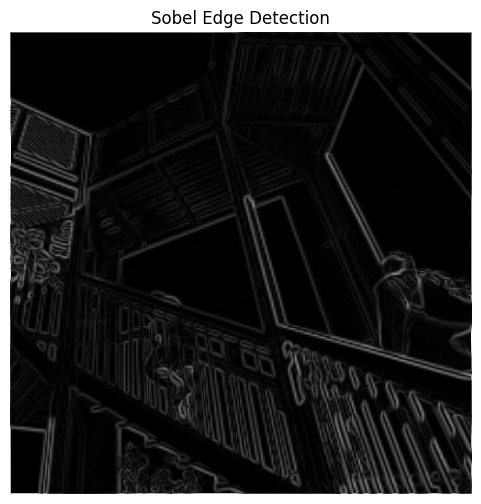

In [3]:
from PIL import Image
import matplotlib.pyplot as plt 

def apply_sobel_filter_and_display(image_path):
   
    image = Image.open(image_path).convert('L')
    img_array = np.array(image, dtype=np.float64)

    
    B, C_in = 1, 1  # Single image, single channel
    H, W = img_array.shape
    input_array = img_array.reshape(B, C_in, H, W)

    
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float64)
    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]], dtype=np.float64)

    
    C_out = 1  
    sobel_x = sobel_x.reshape(C_out, C_in, 3, 3)
    sobel_y = sobel_y.reshape(C_out, C_in, 3, 3)

    
    convolver = FFTConvolver()

    
    grad_x = convolver.convolve(input_array, sobel_x, stride=1, padding=1)
    grad_y = convolver.convolve(input_array, sobel_y, stride=1, padding=1)

    
    grad_x = grad_x.squeeze()  
    grad_y = grad_y.squeeze()  

    
    magnitude = np.sqrt(grad_x**2 + grad_y**2)

    
    magnitude = (magnitude / magnitude.max() * 255).astype(np.uint8)

    
    plt.figure(figsize=(8, 6))
    plt.imshow(magnitude, cmap='gray')
    plt.title('Sobel Edge Detection')
    plt.axis('off')
    plt.show()

apply_sobel_filter_and_display(input_image)